# Phase 2: Customer Segmentation (RFM & Clustering)

**Objective:** Perform customer segmentation to identify 'Loyal Spenders', 'Potential Loyalists', and 'At-Risk' customers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px

# Configuration for cleaner charts
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Preprocessed Data
We load the cleaned data generated in the previous phase (`online_retail_cleaned.csv`).

In [2]:
print("Loading dataset...")
try:
    df = pd.read_csv('online_retail_cleaned.csv')
except FileNotFoundError:
    raise FileNotFoundError("Error: 'online_retail_cleaned.csv' not found. Please ensure it is in the project directory.")

# Ensure correct data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Use pandas nullable integer dtype to allow NA values without raising on cast
# Coerce non-numeric values to NaN first, then convert to Int64 (nullable integer)
df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce').astype('Int64')
missing_cust = int(df['CustomerID'].isna().sum())
if missing_cust:
    print(f"Warning: CustomerID contains {missing_cust:,} missing values.\n" 
          "For customer-level segmentation you should drop or impute these rows;\n" 
          "they are kept here (nullable Int) so aggregate analyses still include them).")

print(f"Data Loaded: {df.shape[0]} rows")

df.head()

Loading dataset...
For customer-level segmentation you should drop or impute these rows;
they are kept here (nullable Int) so aggregate analyses still include them).
Data Loaded: 522569 rows


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Month,Day,DayOfWeek,Hour,Quarter,DayName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,2,8,4,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,4,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,2,8,4,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,4,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,4,Wednesday


## 2. RFM Feature Engineering
We calculate the Recency, Frequency, and Monetary metrics for each customer.

* **Recency:** Days since last purchase (relative to snapshot date).
* **Frequency:** Number of unique invoices.
* **Monetary:** Total sum of sales.

In [3]:
print("Calculating RFM metrics...")

# Set a reference date (1 day after the max date in data)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID to calculate RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'Sales': 'sum'                                            # Monetary
})

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'Sales': 'Monetary'}, inplace=True)

# Filter out invalid monetary values (zero or negative)
rfm = rfm[rfm['Monetary'] > 0]
print(f"Unique Customers for Analysis: {rfm.shape[0]}")
rfm.head()

Calculating RFM metrics...
Unique Customers for Analysis: 4334


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1437.24
12349,19,1,1457.55
12350,310,1,294.40


## 3. Exploratory Data Analysis (EDA)
Before clustering, let's visualize the distributions of Recency, Frequency, and Monetary to understand the data skewness.

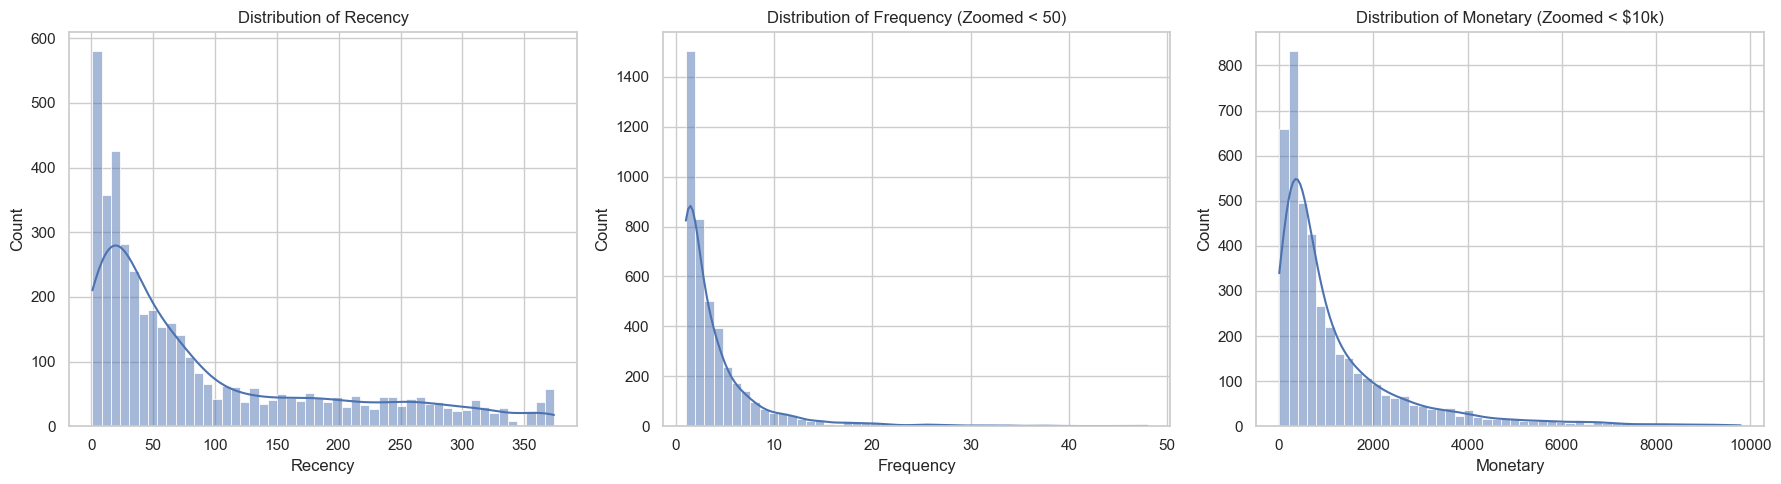

In [4]:
# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Recency')

# Limit Frequency to < 50 for better visualization as it has extreme outliers
sns.histplot(rfm[rfm['Frequency'] < 50]['Frequency'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Frequency (Zoomed < 50)')

# Limit Monetary to < 10000 for better visualization
sns.histplot(rfm[rfm['Monetary'] < 10000]['Monetary'], bins=50, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Monetary (Zoomed < $10k)')

plt.tight_layout()
plt.show()

Applying Log Transformation and Scaling...


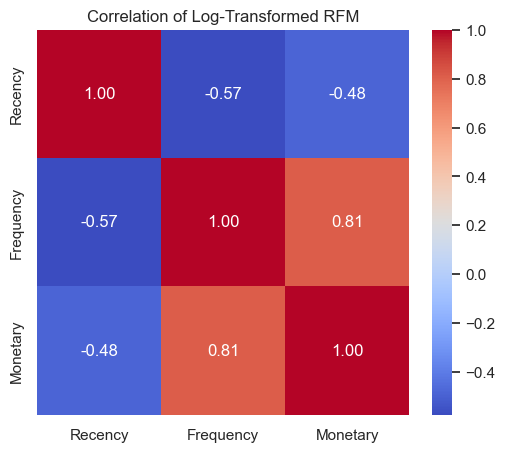

In [5]:
print("Applying Log Transformation and Scaling...")

# Log Transformation to handle skewness
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log10, axis=1)

# Standard Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm_log.columns)

# Visualize Correlation Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(rfm_log.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Log-Transformed RFM')
plt.show()

## 5. Determining Optimal K (Silhouette Score)
Although the project plan specifies 3 clusters, it is best practice to use the Elbow Method to verify the optimal number of clusters.

Silhouette scores and inertia for k=2..10:

    silhouette_score      inertia
k                                
2           0.431996  6389.453692
3           0.340657  4839.698421
4           0.335103  3953.752154
5           0.305922  3383.514152
6           0.310398  2900.450387
7           0.308222  2608.637366
8           0.294231  2398.515320
9           0.281833  2212.149523
10          0.288490  2041.171245


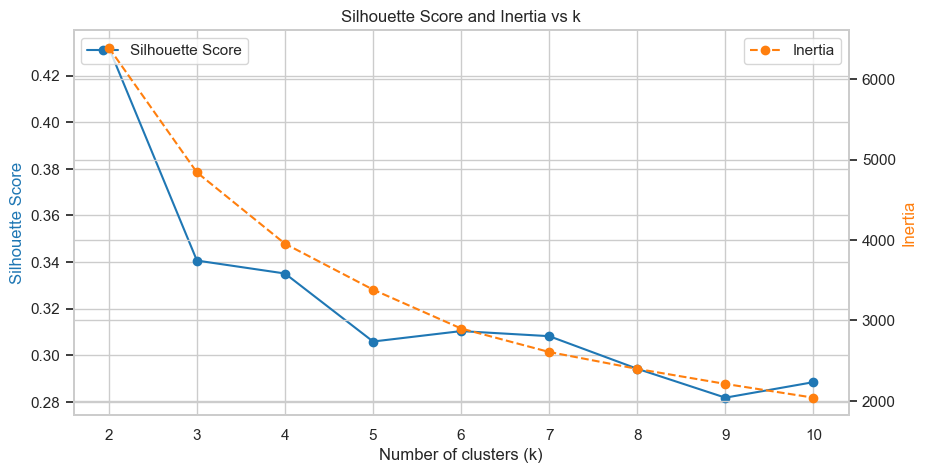


Best k by silhouette score: 2 (silhouette=0.4320)


In [6]:
# Use the Silhouette Score to evaluate the best K
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(2, 11)  # silhouette requires at least 2 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, labels)
    sil_scores.append({'k': k, 'silhouette_score': score, 'inertia': kmeans.inertia_})

sil_df = pd.DataFrame(sil_scores).set_index('k')
print("Silhouette scores and inertia for k=2..10:\n")
print(sil_df)

# Plot silhouette scores and inertia on twin axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(sil_df.index, sil_df['silhouette_score'], marker='o', color='#1f77b4', label='Silhouette Score')
ax2.plot(sil_df.index, sil_df['inertia'], marker='o', color='#ff7f0e', linestyle='--', label='Inertia')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_xticks(list(sil_df.index))
ax1.set_ylabel('Silhouette Score', color='#1f77b4')
ax2.set_ylabel('Inertia', color='#ff7f0e')
ax1.set_title('Silhouette Score and Inertia vs k')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# Choose best k as the k with maximum silhouette score
best_k = int(sil_df['silhouette_score'].idxmax())
best_score = sil_df.loc[best_k, 'silhouette_score']
print(f"\nBest k by silhouette score: {best_k} (silhouette={best_score:.4f})")

# Save sil_df to notebook namespace for later review
silhouette_results = sil_df.copy()

## 6. K-Means Clustering
We proceed with **K=3** based on the project plan and (business-driven choice).

In [7]:
print("\nRunning final clustering with k = 3 (business-driven choice)...")

# 🔁 CHANGED: We FIRST identify New Customers by rule, and EXCLUDE them from K-Means.

NEW_CUSTOMER_DAYS = 30  # threshold for "recent"
new_mask = (rfm['Frequency'] == 1) & (rfm['Recency'] <= NEW_CUSTOMER_DAYS)

rfm_new = rfm[new_mask].copy()
rfm_existing = rfm[~new_mask].copy()

print(f"New Customers identified (Frequency=1 & Recency <= {NEW_CUSTOMER_DAYS}): {rfm_new.shape[0]}")
print(f"Customers used for clustering (existing): {rfm_existing.shape[0]}")

# 🔁 CHANGED: We use k = 3 for behavioural segments: Loyal, Potential, At-Risk.
k_for_segmentation = 3

existing_ids = rfm_existing.index
X_existing = rfm_scaled_df.loc[existing_ids, ['Recency', 'Frequency', 'Monetary']]

kmeans = KMeans(n_clusters=k_for_segmentation, random_state=42, n_init=10)
rfm_existing['Cluster'] = kmeans.fit_predict(X_existing)

# Show the count of customers in each cluster
rfm_existing['Cluster'].value_counts()


Running final clustering with k = 3 (business-driven choice)...
New Customers identified (Frequency=1 & Recency <= 30): 220
Customers used for clustering (existing): 4114


Cluster
1    1689
0    1664
2     761
Name: count, dtype: int64

## 7. Cluster Interpretation & Labeling
Analyzing the average RFM values to map arbitrary Cluster IDs to business segments.

In [8]:
print("\nInterpreting and labeling clusters...")

cluster_summary = (
    rfm_existing.groupby('Cluster')
    .agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Cluster': 'count'
    })
    .rename(columns={'Cluster': 'Count'})
)

print("\nCluster Summary (on existing customers):")
print(cluster_summary)

# Determine which cluster is which:
# 1) Loyal Spenders = highest Monetary
loyal_cluster = cluster_summary['Monetary'].idxmax()

# 2) At-Risk = highest Recency (they haven't purchased for the longest time)
at_risk_cluster = cluster_summary['Recency'].idxmax()

# 3) Potential Loyalists = the remaining one with mid-level RFM
remaining = [c for c in cluster_summary.index if c not in [loyal_cluster, at_risk_cluster]]
potential_cluster = remaining[0] if remaining else loyal_cluster  # safety fallback

label_map = {
    loyal_cluster: 'Loyal Spenders',
    at_risk_cluster: 'At-Risk Customers',
    potential_cluster: 'Potential Loyalists'
}

rfm_existing['Segment'] = rfm_existing['Cluster'].map(label_map)

# ✅ NEW: Label New Customers explicitly
rfm_new['Segment'] = 'New Customers'

# ✅ NEW: Combine existing + new into final RFM segmentation table
rfm_final = pd.concat([rfm_existing, rfm_new], axis=0).sort_index()

print("\nFinal Segment Distribution (% of customers):")
print(rfm_final['Segment'].value_counts(normalize=True) * 100)

# For convenience, keep `rfm` pointing to the final table
rfm = rfm_final.copy()

# Save results
rfm.to_csv('rfm_analysis_results.csv')
print("\nResults saved to 'rfm_analysis_results.csv'")


Interpreting and labeling clusters...

Cluster Summary (on existing customers):
            Recency  Frequency     Monetary  Count
Cluster                                           
0         53.200721   3.625601  1377.427434   1664
1        177.587922   1.300770   354.872179   1689
2         12.350854  13.077530  7595.227714    761

Final Segment Distribution (% of customers):
Segment
At-Risk Customers      38.970928
Potential Loyalists    38.394093
Loyal Spenders         17.558837
New Customers           5.076142
Name: proportion, dtype: float64

Results saved to 'rfm_analysis_results.csv'


## 8. Detailed Cluster Profiling
We visualize the differences between the segments using Box Plots and a Snake Plot.

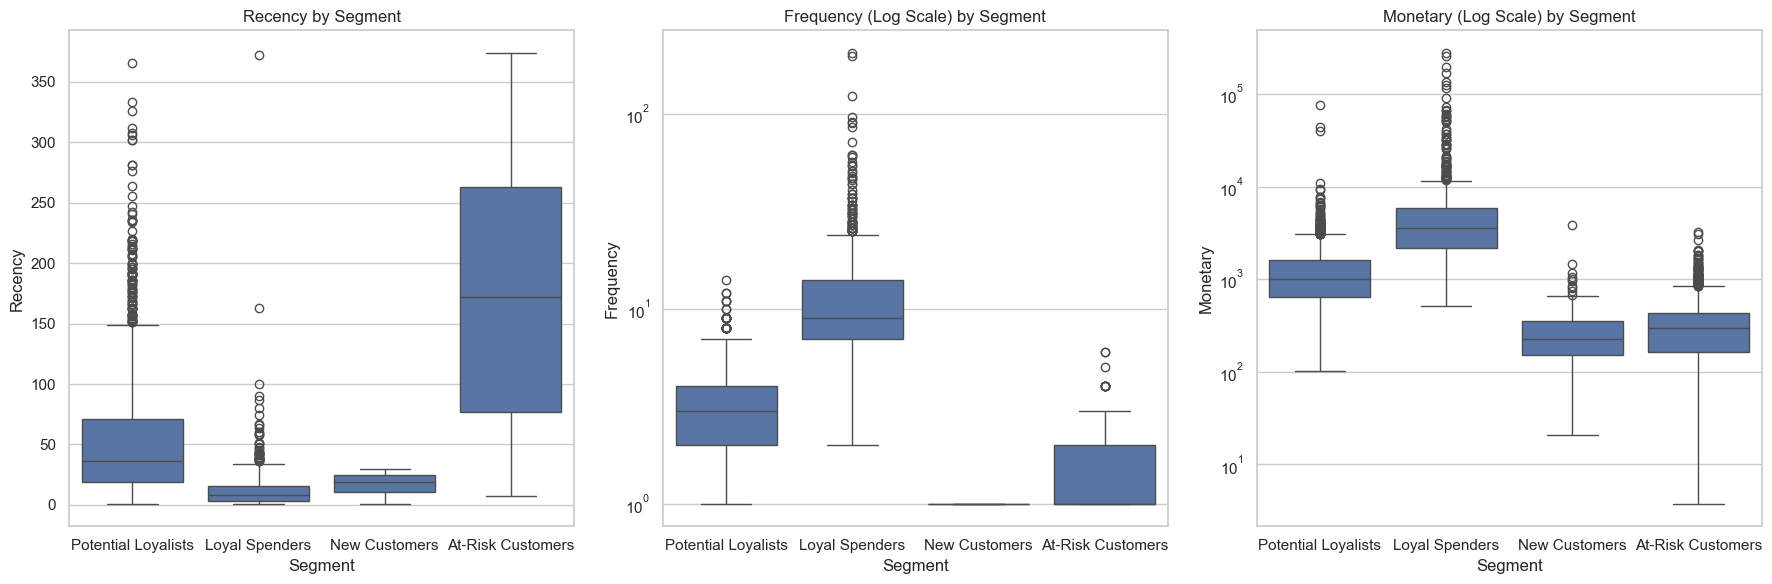

In [9]:
# 1. Box Plots for RFM Distribution by Segment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='Segment', y='Recency', data=rfm, ax=axes[0])
axes[0].set_title('Recency by Segment')

# Log scale helps visualization of skewed data in boxplots
sns.boxplot(x='Segment', y='Frequency', data=rfm, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Frequency (Log Scale) by Segment')

sns.boxplot(x='Segment', y='Monetary', data=rfm, ax=axes[2])
axes[2].set_yscale('log')
axes[2].set_title('Monetary (Log Scale) by Segment')

plt.tight_layout()
plt.show()

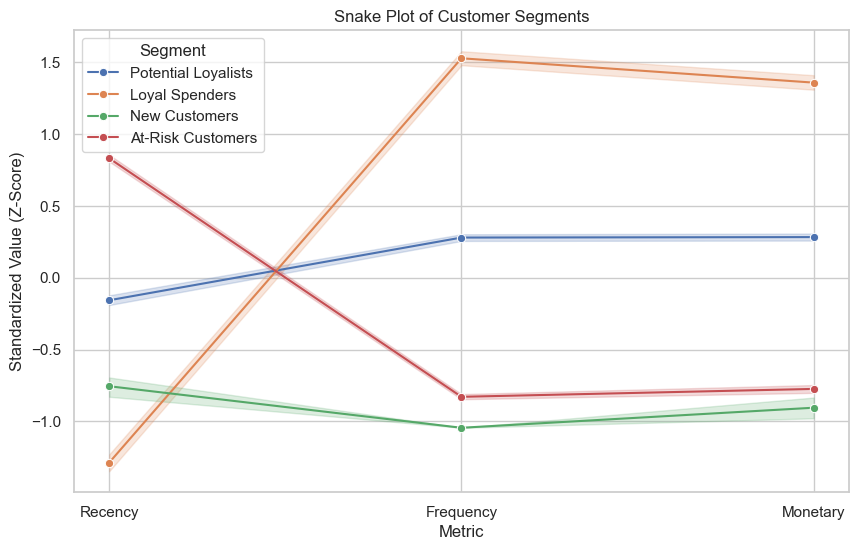

In [10]:
# 2. Snake Plot: RFM profile per segment (using scaled values)
rfm_scaled_df['Segment'] = rfm['Segment']

rfm_melt = pd.melt(
    rfm_scaled_df.reset_index(),
    id_vars=['CustomerID', 'Segment'],
    value_vars=['Recency', 'Frequency', 'Monetary'],
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Metric', y='Value', hue='Segment', data=rfm_melt, marker='o')
plt.title('Snake Plot of Customer Segments')
plt.xlabel('Metric')
plt.ylabel('Standardized Value (Z-Score)')
plt.legend(title='Segment')
plt.show()